In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

Visualisasi data dan mencoba liat hasil melalui Rule-Based.

In [2]:
# --- Load datasets ---
ds_temp = xr.open_dataset("dataset/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1754328683435.nc")
ds_chlor = xr.open_dataset("dataset/cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m_1754328302683.nc")
ds_velocity = xr.open_dataset("dataset/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1754328993629.nc")

# --- Pick surface level only ---
ds_temp_surface = ds_temp.sel(depth=ds_temp.depth[0])
ds_chlor_surface = ds_chlor.sel(depth=ds_chlor.depth[0])
ds_velocity_surface = ds_velocity.sel(depth=ds_velocity.depth[0])

# --- Pick one time slice (first day) ---
ds_temp_t0 = ds_temp_surface.isel(time=0)
ds_chlor_t0 = ds_chlor_surface.isel(time=0)
ds_velocity_t0 = ds_velocity_surface.isel(time=0)

# --- Interpolate chlorophyll to match temp/velocity grid ---
ds_chlor_t0_interp = ds_chlor_t0.interp(
    latitude=ds_temp_t0.latitude, longitude=ds_temp_t0.longitude, method="linear"
)

# --- Combine all into one DataFrame ---
lat = ds_temp_t0.latitude.values
lon = ds_temp_t0.longitude.values

# Flatten all grids
def flatten_grid(da):
    return da.values.flatten()

df = pd.DataFrame({
    'latitude': np.repeat(lat, len(lon)),
    'longitude': np.tile(lon, len(lat)),
    'temperature': flatten_grid(ds_temp_t0['thetao']),
    'chlorophyll': flatten_grid(ds_chlor_t0_interp['chl']),
    'u_velocity': flatten_grid(ds_velocity_t0['uo']),
    'v_velocity': flatten_grid(ds_velocity_t0['vo']),
})

# --- Drop NaNs (invalid/missing ocean grid points) ---
df = df.dropna()

print("Sample of merged dataset:")
print(df.head())


Sample of merged dataset:
   latitude  longitude  temperature  chlorophyll  u_velocity  v_velocity
0     -15.0  90.000015    26.985268     0.080801   -0.378120   -0.050193
1     -15.0  90.083351    26.977972     0.080607   -0.376146   -0.041942
2     -15.0  90.166679    26.964743     0.080414   -0.374880   -0.034063
3     -15.0  90.250015    26.948877     0.080221   -0.375208   -0.027170
4     -15.0  90.333351    26.928963     0.079897   -0.375587   -0.021455


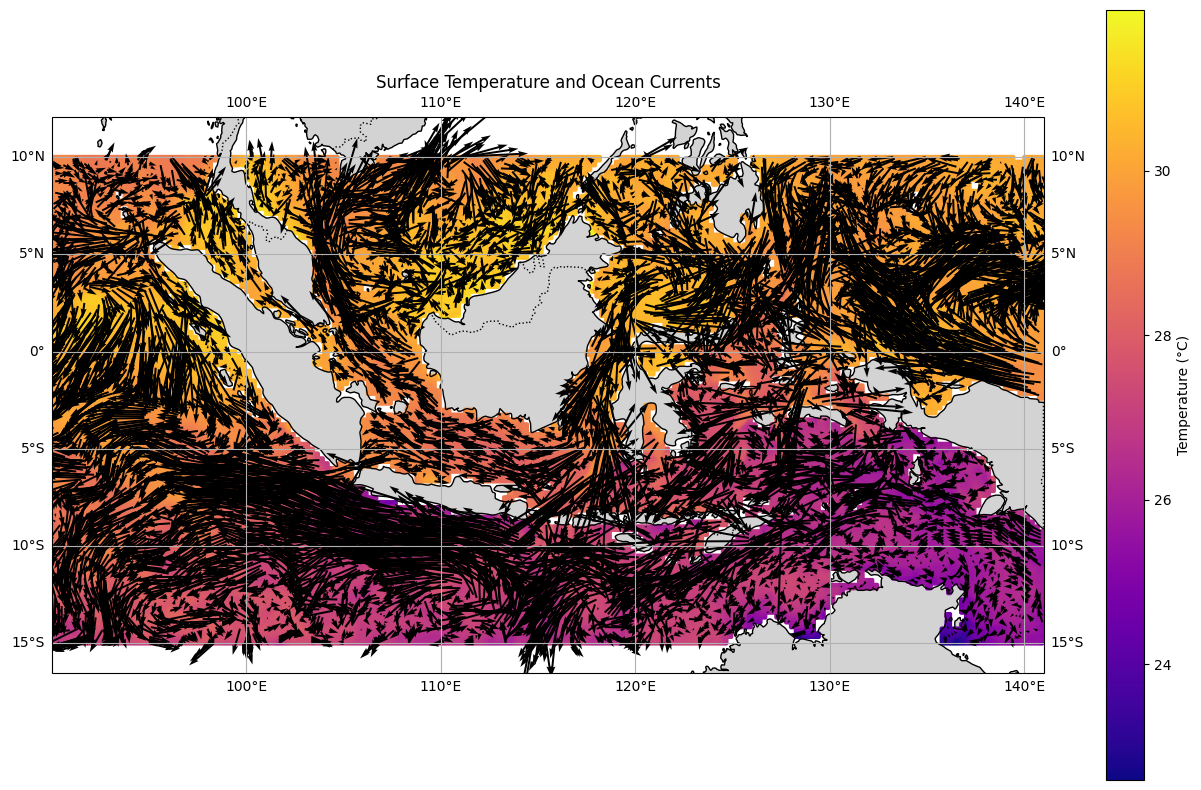

In [3]:
# Set up plot
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([90, 141, -15, 11])

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# Plot temperature as heatmap
sc = ax.scatter(
    df['longitude'], df['latitude'], c=df['temperature'],
    cmap='plasma', s=5, transform=ccrs.PlateCarree()
)

# Plot velocity vectors (downsampled)
skip = 20  # change this to reduce arrow density
ax.quiver(
    df['longitude'][::skip], df['latitude'][::skip],
    df['u_velocity'][::skip], df['v_velocity'][::skip],
    scale=10, width=0.002, transform=ccrs.PlateCarree(), color='black'
)

plt.title("Surface Temperature and Ocean Currents")
plt.colorbar(sc, label="Temperature (°C)")
plt.show()


Rule-based approach dan melihat probabilitas tanpa model.

HSI shape: (301, 612)
Total points: 184212
High-suitability points: 19845


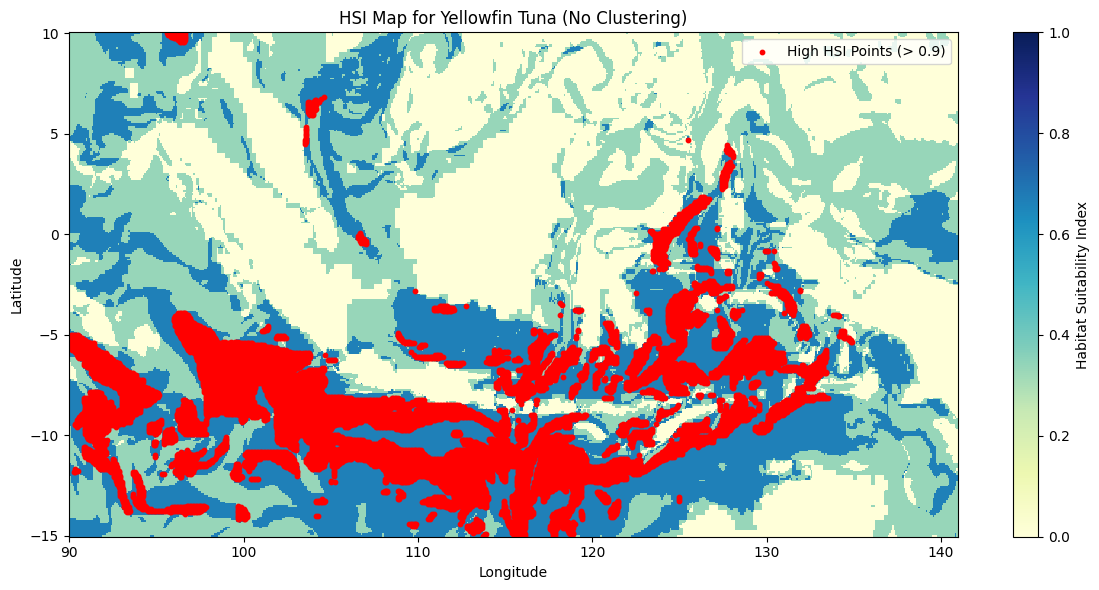

In [ ]:
# Ini ga pake model apa-apa, cuman rule-based approach buat HSI
# === Load datasets === 
ds_temp = xr.open_dataset("dataset/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1754328683435.nc")
ds_chlor = xr.open_dataset("dataset/cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m_1754328302683.nc")
ds_velocity = xr.open_dataset("dataset/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1754328993629.nc")

# === Select surface data ===
temp = ds_temp['thetao'].isel(time=0, depth=0)
chlor = ds_chlor['chl'].isel(time=0, depth=0)
u = ds_velocity['uo'].isel(time=0, depth=0)
v = ds_velocity['vo'].isel(time=0, depth=0)

# === Interpolate chlorophyll to temp grid ===
chlor_interp = chlor.interp(
    latitude=temp.latitude,
    longitude=temp.longitude,
    method="linear"
).fillna(0)

# === Compute current speed ===
current_speed = np.sqrt(u**2 + v**2)

# === Apply Yellowfin Tuna environmental filters ===
suitable_temp = (temp >= 26) & (temp <= 29)
suitable_chlor = (chlor_interp >= 0.15) & (chlor_interp <= 0.7)
suitable_current = (current_speed >= 0.3) & (current_speed <= 0.8)

# === Compute Habitat Suitability Index (HSI) ===
HSI = (suitable_temp.astype(float) + suitable_chlor.astype(float) + suitable_current.astype(float)) / 3

# === Extract high-HSI points ===
lat, lon = np.meshgrid(temp.latitude, temp.longitude, indexing='ij')
mask = HSI.values > 0.7
points = np.array([lon[mask], lat[mask]]).T

# === Print diagnostics ===
print("HSI shape:", HSI.shape)
print("Total points:", HSI.size)
print("High-suitability points:", np.sum(mask))

# === Plot HSI Heatmap + high-suitability points ===
plt.figure(figsize=(12, 6))
plt.pcolormesh(temp.longitude, temp.latitude, HSI, cmap='YlGnBu', shading='auto')
plt.colorbar(label='Habitat Suitability Index')
plt.scatter(points[:, 0], points[:, 1], color='red', s=10, label="High HSI Points (> 0.7)")
plt.title("HSI Map for Yellowfin Tuna (No Clustering)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

Melihat probabilitas melalui Clustering.

('latitude', 'longitude')
('latitude', 'longitude')
('latitude', 'longitude')
('latitude', 'longitude')

Cluster centroids in real-world units:
            Latitude   Longitude  Temperature (°C)  Chlorophyll-a (mg/m³)  \
Cluster ID                                                                  
0            -10.355  117.200996         27.080000                  0.272   
1             -0.190   98.646004         29.594000                  0.219   
2             -7.805  126.496002         26.729000                  1.096   
3             -2.585  120.717003         28.847000                  0.255   
4              5.048  126.250999         30.089001                  0.122   

            Current Speed (m/s)  
Cluster ID                       
0                         0.230  
1                         0.275  
2                         0.271  
3                         0.766  
4                         0.268  


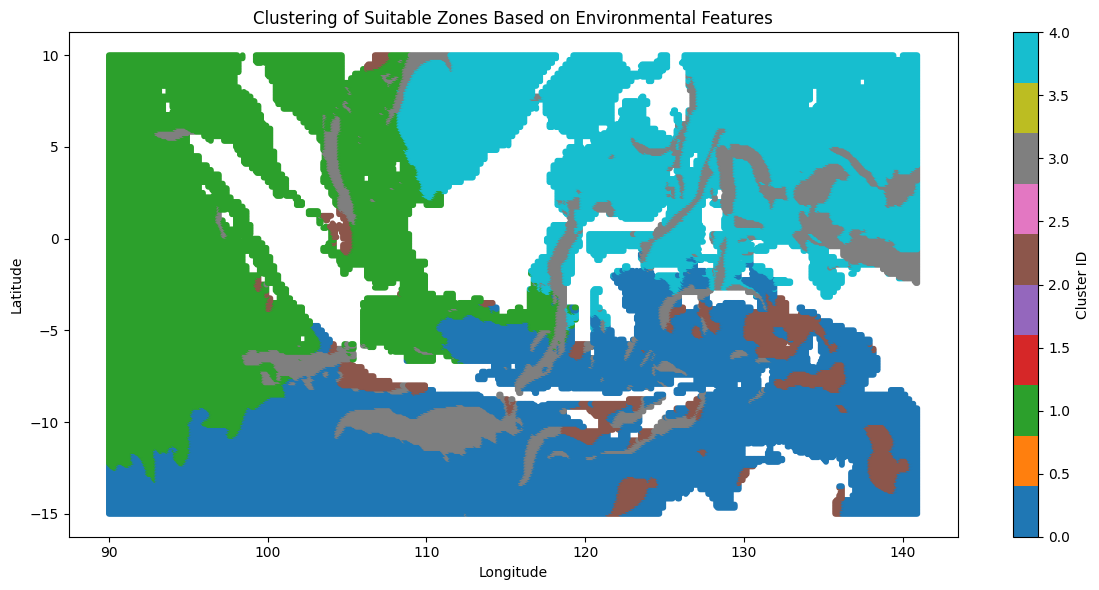

In [ ]:
# Flatten all data arrays
lat_vals = temp.latitude.values
lon_vals = temp.longitude.values
lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')

# Select surface layer and time
temp = ds_temp['thetao'].isel(time=0, depth=0)
chlor = ds_chlor['chl'].isel(time=0, depth=0)
u = ds_velocity['uo'].isel(time=0, depth=0)
v = ds_velocity['vo'].isel(time=0, depth=0)

# Interpolate chlorophyll and currents to temp grid
chlor_interp = chlor.interp_like(temp)
u_interp = u.interp_like(temp)
v_interp = v.interp_like(temp)

# Compute HSI again if needed
def gaussian_suitability(x, optimal, sigma):
    """Returns suitability score (0–1) using Gaussian function centered at optimal."""
    return np.exp(-0.5 * ((x - optimal) / sigma) ** 2)

# Suitability components
temp_suit = gaussian_suitability(temp, optimal=28, sigma=1.5)  # Optimal 28°C
chlor_suit = gaussian_suitability(chlor_interp, optimal=0.7, sigma=0.4)  # Optimal 0.7 mg/m³
current_speed = np.sqrt(u_interp**2 + v_interp**2)
current_suit = gaussian_suitability(current_speed, optimal=0.4, sigma=0.2)  # Optimal 0.4 m/s

# Combined HSI (weighted geometric mean or average)
hsi = (temp_suit * chlor_suit * current_suit) ** (1/3)  # geometric mean

# Filter high-HSI points
mask = hsi.values > 0  # binary HSI
lat_points = lat_grid[mask]
lon_points = lon_grid[mask]
temp_points = temp.values[mask]
chlor_points = chlor_interp.values[mask]
current_points = current_speed.values[mask]

# Combine into feature matrix
features = np.stack([lat_points, lon_points, temp_points, chlor_points, current_points], axis=1)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering
n_clusters = 5  # or choose dynamically
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# Inverse transform to get real-world values from centroids
centroids_scaled = kmeans.cluster_centers_
centroids_real = scaler.inverse_transform(centroids_scaled)

# Create DataFrame for clarity
centroids_df = pd.DataFrame(
    centroids_real,
    columns=["Latitude", "Longitude", "Temperature (°C)", "Chlorophyll-a (mg/m³)", "Current Speed (m/s)"]
)
centroids_df.index.name = "Cluster ID"

# Print centroids
print("\nCluster centroids in real-world units:")
print(centroids_df.round(3))

# Plotting the clusters
plt.figure(figsize=(12, 6))
scatter = plt.scatter(lon_points, lat_points, c=labels, cmap='tab10', s=10)
plt.title("Clustering of Suitable Zones Based on Environmental Features")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()


Clustering dari spatial dan HSI.


Cluster centroids (based on HSI and location):
            Latitude   Longitude    HSI
Cluster ID                             
0             -7.672  122.134003  0.702
1              4.675  101.122002  0.449
2             -8.716   99.582001  0.655
3            -10.433  126.973000  0.400
4              4.504  129.695007  0.418


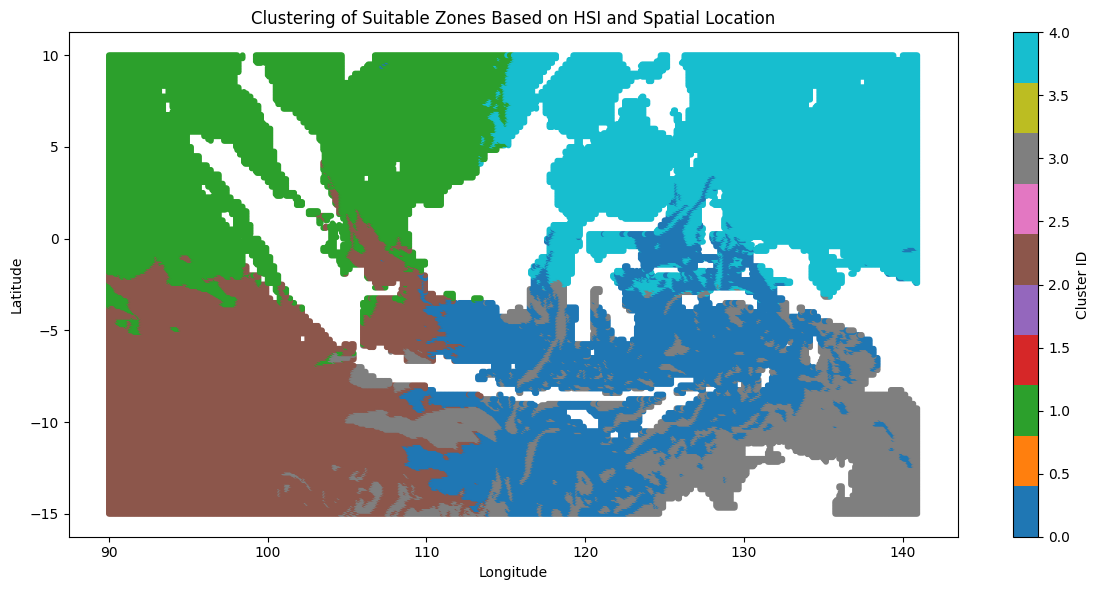

In [ ]:
temp = ds_temp['thetao'].isel(time=0, depth=0)
chlor = ds_chlor['chl'].isel(time=0, depth=0)
u = ds_velocity['uo'].isel(time=0, depth=0)
v = ds_velocity['vo'].isel(time=0, depth=0)

# Interpolate chlorophyll and current data to match temp grid
chlor_interp = chlor.interp_like(temp)
u_interp = u.interp_like(temp)
v_interp = v.interp_like(temp)

# Create lat/lon grid
lat_vals = temp.latitude.values
lon_vals = temp.longitude.values
lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')

# --- Gaussian Suitability Function ---
def gaussian_suitability(x, optimal, sigma):
    return np.exp(-0.5 * ((x - optimal) / sigma) ** 2)

# --- Compute Suitability ---
temp_suit = gaussian_suitability(temp, optimal=28, sigma=1.5)
chlor_suit = gaussian_suitability(chlor_interp, optimal=0.7, sigma=0.4)
current_speed = np.sqrt(u_interp**2 + v_interp**2)
current_suit = gaussian_suitability(current_speed, optimal=0.4, sigma=0.2)

# --- Habitat Suitability Index (HSI) ---
hsi = (temp_suit * chlor_suit * current_suit) ** (1/3)  # geometric mean

# --- Mask high HSI points ---
mask = hsi.values > 0  # could use threshold like > 0.5
lat_points = lat_grid[mask]
lon_points = lon_grid[mask]
hsi_points = hsi.values[mask]

# --- Feature Matrix: [Latitude, Longitude, HSI] ---
features = np.stack([lat_points, lon_points, hsi_points], axis=1)

# --- Standardize ---
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- Clustering ---
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# --- Inverse transform to get centroids ---
centroids_scaled = kmeans.cluster_centers_
centroids_real = scaler.inverse_transform(centroids_scaled)

# --- Create DataFrame for centroids ---
centroids_df = pd.DataFrame(
    centroids_real,
    columns=["Latitude", "Longitude", "HSI"]
)
centroids_df.index.name = "Cluster ID"

# --- Print the Centroids ---
print("\nCluster centroids (based on HSI and location):")
print(centroids_df.round(3))

# --- Plot the Clusters ---
plt.figure(figsize=(12, 6))
scatter = plt.scatter(lon_points, lat_points, c=labels, cmap='tab10', s=10)
plt.title("Clustering of Suitable Zones Based on HSI and Spatial Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()


Ngetes make TIF dan GEOJSON dari Apparent Fishing Activity

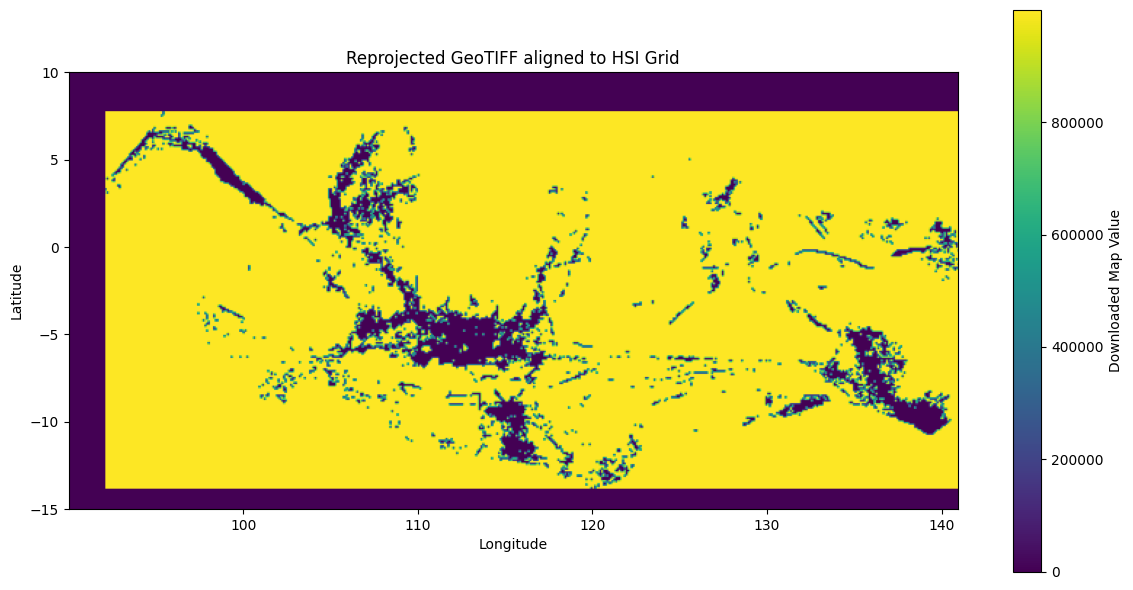

In [ ]:
# Open the GeoTIFF
with rasterio.open("dataset/layer-activity-data-0/public-global-fishing-effort-v3.0.tif") as src:
    downloaded_data = src.read(1)  # Read first band
    downloaded_crs = src.crs
    downloaded_bounds = src.bounds

# === Create transform for HSI grid ===
transform_hsi = from_bounds(
    west=lon_vals.min(),
    south=lat_vals.min(),
    east=lon_vals.max(),
    north=lat_vals.max(),
    width=HSI.shape[1],
    height=HSI.shape[0]
)

# === Prepare empty array for resampled data ===
downloaded_resampled = np.zeros_like(HSI.values)

# === Reproject (resample) GeoTIFF to HSI grid ===
reproject(
    source=downloaded_data,
    destination=downloaded_resampled,
    src_transform=src.transform,
    src_crs=downloaded_crs,
    dst_transform=transform_hsi,
    dst_crs="EPSG:4326",
    dst_resolution=None,
    resampling=Resampling.bilinear
)

# === Plot to verify alignment ===
plt.figure(figsize=(12, 6))
plt.imshow(downloaded_resampled, origin='upper',
           extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
           cmap='viridis')
plt.title("Reprojected GeoTIFF aligned to HSI Grid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Downloaded Map Value')
plt.tight_layout()
plt.show()


Pemodelan dengan Apparent Fishing Activity

In [72]:
current_magnitude = np.sqrt(ds_velocity['uo']**2 + ds_velocity['vo']**2)

# Aggregate to annual mean (assumes 'time' dimension covers the full year)
temp_annual = ds_temp['thetao'].sel(depth=0, method='nearest').mean(dim='time')
chlor_annual = ds_chlor['chl'].mean(dim='time')
chlor_annual = chlor_annual.squeeze() 
current_annual = current_magnitude.mean(dim='time')
current_annual = current_annual.squeeze()
fishing_effort = downloaded_resampled 

temp_annual = temp_annual.rename({'latitude': 'lat', 'longitude': 'lon'})
current_annual = current_annual.rename({'latitude': 'lat', 'longitude': 'lon'})

fishing_effort = xr.DataArray(
    fishing_effort,
    dims=("lat", "lon"),
    coords={
        "lat": temp_annual["lat"],
        "lon": temp_annual["lon"]
    }
)

# Buat chlor_annual jadi xarray dengan koordinat yang bisa diinterpolasi
chlor_da = xr.DataArray(
    chlor_annual.values,
    dims=("lat", "lon"),
    coords={
        "lat": ds_chlor["lat"],
        "lon": ds_chlor["lon"]
    }
)

# Interpolasi ke grid temp_annual
chlor_interp = chlor_da.interp_like(temp_annual, method="linear")
chlor_interp = chlor_interp.squeeze()

mask = np.isfinite(temp_annual.values) & (fishing_effort > 0)

print(temp_annual.shape)       # (301, 612)
print(chlor_interp.shape)      # (301, 612)
print(current_annual.shape)    # (301, 612)
print(HSI.shape)               # (301, 612)
print(fishing_effort.shape)    # (301, 612)

X = np.stack([
    temp_annual.values.flatten(),
    chlor_interp.values.flatten(),
    current_annual.values.flatten(),
    HSI.values.flatten(),
], axis=1)

y = fishing_effort.values.flatten()

X = X[mask.values.flatten()]
y = y[mask.values.flatten()]

(301, 612)
(301, 612)
(301, 612)
(301, 612)
(301, 612)


In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1. Imputasi
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_np)

# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. Polynomial expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# 4. Train-test split
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# 5. Train model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# 6. Predict & Evaluate
y_pred = model.predict(X_test_poly)
np.sqrt(mean_squared_error(y_test, y_pred))
print("Polynomial Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Polynomial Linear R²:", r2_score(y_test, y_pred))


Polynomial Linear RMSE: 211041.91922543335
Polynomial Linear R²: 0.03139668256135619


In [ ]:
# Tetap pakai data X_scaled hasil imputasi + scaling (tanpa polynomial)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict & evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 152645.05694316572
Random Forest R²: 0.4932730679832734


In [ ]:
hgb_model = HistGradientBoostingRegressor(random_state=42)
hgb_model.fit(X_train, y_train)

y_pred_hgb = hgb_model.predict(X_test)
print("HistGradientBoosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_hgb)))
print("HistGradientBoosting R²:", r2_score(y_test, y_pred_hgb))

param_grid = {
    "max_iter": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [None, 5, 10],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best RMSE on validation:", -grid.best_score_)

# Evaluate on test set
y_pred_best = grid.predict(X_test)
print("Test RMSE (best HGB):", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Test R²:", r2_score(y_test, y_pred_best))



HistGradientBoosting RMSE: 171618.08261002958
HistGradientBoosting R²: 0.3594772083454765
Best params: {'learning_rate': 0.2, 'max_depth': None, 'max_iter': 300}
Best RMSE on validation: 166579.9718471782
Test RMSE (best HGB): 160610.26355565104
Test R²: 0.4390100432763827


Feature Importance buat efisiensi model.

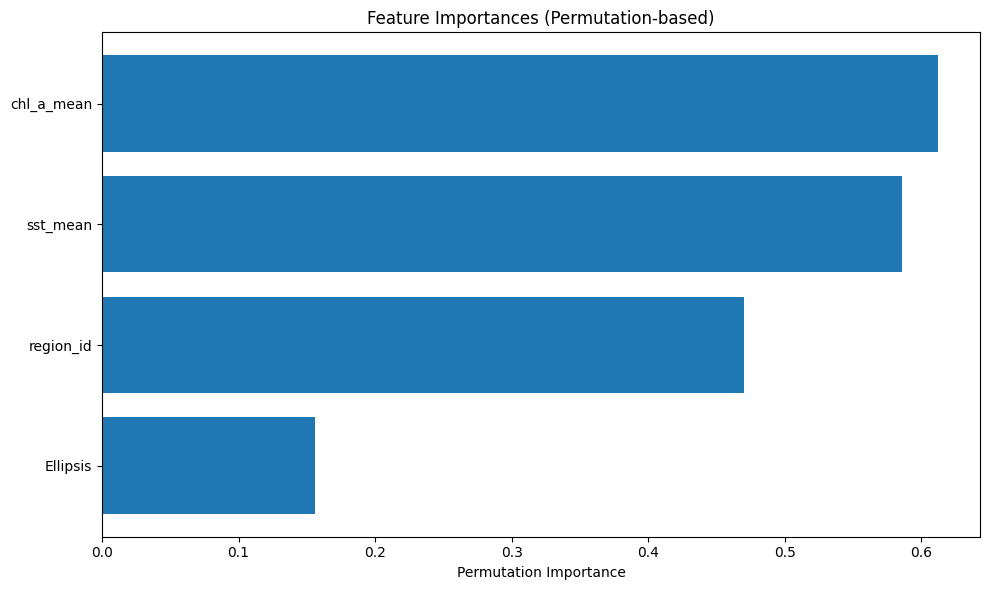

In [ ]:
# Pakai model terbaik dari GridSearchCV
result = permutation_importance(grid.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Ambil dan urutkan
importances = result.importances_mean
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
feature_names = ['sst_mean', 'chl_a_mean', 'region_id', ...]  # isi sesuai fitur
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importances (Permutation-based)")
plt.tight_layout()
plt.show()


In [ ]:
# Gunakan nama fitur sesuai jumlah kolom
feature_names_original = ['sst_mean', 'chl_a_mean', 'region_id', 'year']  # ← 4 nama fitur

# Buat fitur polinomial
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Ambil nama-nama fitur hasil ekspansi
feature_names = poly.get_feature_names_out(input_features=feature_names_original)

# Split data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Fit model
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train_poly, y_train)

# Importance via permutation
result = permutation_importance(model, X_test_poly, y_test, n_repeats=10, random_state=42)

# DataFrame untuk hasil importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Tampilkan 10 fitur teratas
print(importance_df.head(10))


                 Feature  Importance
0               sst_mean    0.212539
1             chl_a_mean    0.153624
5    sst_mean chl_a_mean    0.128458
4             sst_mean^2    0.108165
9   chl_a_mean region_id    0.073979
12        region_id year    0.070411
7          sst_mean year    0.063165
11           region_id^2    0.058121
6     sst_mean region_id    0.055213
8           chl_a_mean^2    0.049596


Pemodelan dengan XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


XGBoost RMSE: 170226.11112100014
XGBoost R²: 0.36982546149749007


Hyperparameter XGBoost.

In [ ]:
param_grid = {
    "n_estimators": [100, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8]
}

grid_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train_scaled, y_train)

print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best Validation RMSE:", -grid_xgb.best_score_)

# Final model
best_xgb = grid_xgb.best_estimator_
y_pred_best = best_xgb.predict(X_test_scaled)

print("Test RMSE (best XGBoost):", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Test R² (best XGBoost):", r2_score(y_test, y_pred_best))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}
Best Validation RMSE: 168718.8553067355
Test RMSE (best XGBoost): 163741.92675302006
Test R² (best XGBoost): 0.4169198060211091
